## `refpix` step

This step corrects for additional signal added by the readout electronics by using the reference pixels. The magnitude of this variation is of the order of a few counts. In addition, superposed on this signal is a variation that is mainly with row number that seems to apply to all amplifiers within a group.

Official documentation for `refpix` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/refpix/index.html>


### Input data

An example of running the `refpix` step is now shown using a simple simulated observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.1](http://miri.ster.kuleuven.be/bin/view/Public/MIRISimPublicRelease2dot1), with precending pipeline steps applied, i.e. `dark_current` output.

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from jwst import datamodels

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0535.pmap"

Import `refpix` and print the docstring and spec to show some information

In [2]:
# import the step
from jwst.refpix import refpix_step

# print the description and options
print(refpix_step.RefPixStep.__doc__)
print(refpix_step.RefPixStep.spec)




    RefPixStep: Use reference pixels to correct bias drifts

    

        odd_even_columns = boolean(default=True)
        use_side_ref_pixels = boolean(default=True)
        side_smoothing_length = integer(default=11)
        side_gain = float(default=1.0)
        odd_even_rows = boolean(default=True)
    


Set the name of the input file and run the step. This will produce an output file ending with `_refpixstep.fits`

*Parameters used:*

`output_use_model` : boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; propagate the input filename to the output
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file

Note that the `refpix` will return the output datamodel so we set this to the `dm` variable.


In [3]:
# user specified
my_input_file = 'det_image_seq1_MIRIMAGE_F1130Wexp1_darkcurrentstep.fits'

# run the step
dm = refpix_step.RefPixStep.call(my_input_file, output_use_model=True, save_results=True)


2019-07-15 11:30:10,401 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2019-07-15 11:30:10,463 - stpipe.RefPixStep - INFO - Step RefPixStep running with args ('det_image_seq1_MIRIMAGE_F1130Wexp1_darkcurrentstep.fits',).
2019-07-15 11:30:10,854 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True
2019-07-15 11:30:10,855 - stpipe.RefPixStep - INFO - odd_even_columns = True
2019-07-15 11:30:10,855 - stpipe.RefPixStep - INFO - side_smoothing_length = 11
2019-07-15 11:30:10,856 - stpipe.RefPixStep - INFO - side_gain = 1.000000
2019-07-15 11:30:10,856 - stpipe.RefPixStep - INFO - odd_even_rows = True
2019-07-15 11:30:12,304 - stpipe.RefPixStep - INFO - Subtracting initial read from each integration
2019-07-15 11:30:12,920 - stpipe.RefPixStep - INFO - Adding initial read back in
2019-07-15 11:30:14,254 - stpipe.RefPixStep - INFO - Saved model in det_image_seq1_MIRIMAGE_F1130Wexp1_refpixstep.fits
2019-07-15 11:30:14,255 - stpipe.RefPixStep - INFO - Step RefPixStep done


We can plot the before and after ramp of a sample pixel

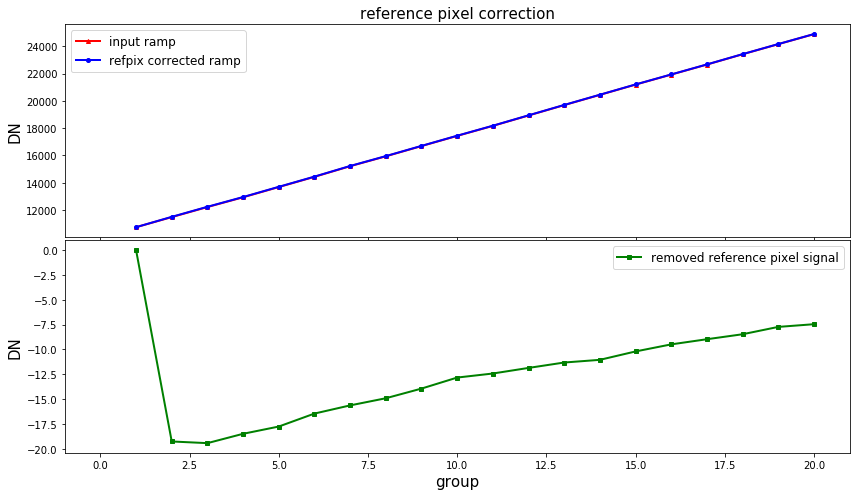

In [4]:
# set the sample pixel
pixel = [600,500]

# define group numbers for integration ramps
group = range(1,dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

# open the input file as a datamodel
in_dm = datamodels.open(my_input_file)

# plot
fig, axs = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# plot input and output ramps of the first integration
axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=4, 
            linestyle='-', linewidth=2, label='input ramp')
axs[0].plot(group, dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', markersize=4, 
            linestyle='-', linewidth=2, label='refpix corrected ramp')
axs[0].set_title('reference pixel correction',fontsize=15)
axs[0].set_ylabel('DN',fontsize=15)
axs[0].set_xlim(-1,max(group)+1)
axs[0].legend(prop={'size':12}, loc=0)

# plot difference which is the removed reference pixel signal
axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - dm.data[0,:,pixel[1],pixel[0]], c='g', 
            marker='s', markersize=4, linestyle='-', linewidth=2, label='removed reference pixel signal')
axs[1].set_ylabel('DN',fontsize=15)
axs[1].set_xlabel('group',fontsize=15)
axs[1].legend(prop={'size':12}, loc=0)

plt.tight_layout(h_pad=0)
plt.show()



### Command line

To achieve the same result from the command line there are a couple of options. 

**Option 1:**
Run the `RefPixStep` class using the `strun` command:

```bash
strun jwst.refpix.RefPixStep det_image_seq1_MIRIMAGE_F1130Wexp1_darkcurrentstep.fits
```

**Option 2:**
If they don't already exist, collect the pipeline configuration files in your working directory using `collect_pipeline_configs` and then run the `RefPixStep` using the `strun` command with the associated `refpix.cfg` file. 

```bash
collect_pipeline_cfgs cfgs/

strun cfgs/refpix.cfg det_image_seq1_MIRIMAGE_F1130Wexp1_darkcurrentstep.fits
```

This will produce the same output file ending with `_refpixstep.fits` 


A full list of the command line options are given by running the following:

```bash
strun jwst.refpix.RefPixStep -h
```

or 

```bash
strun cfgs/refpix.cfg -h
```


### Override reference file

There is currently no reference file for the refpix step.